In [1]:
import pyodbc
import pickle
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

servername = 'LNOR010941'
db = 'NYCTaxi_Sample'
# sql query
query_str = '''
SELECT cast(tipped as int) as tipped,
tip_amount, 
fare_amount 
FROM [dbo].[nyctaxi_sample]'''

query_location = '''
SELECT cast(tipped as int) as tipped,
tip_amount, 
fare_amount 
FROM [dbo].[nyctaxi_sample]'''


In [2]:
#Establish connection to sql server
#connection API: 'DRIVER={SQL Server};SERVER={SERVER_NAME};DATABASE={DB_NAME};UID={USER_NAME};PWD={PASSWORD}'
conn_str = 'Driver=SQL Server;Server=' + servername + \
    ';Database=' + db + ';Trusted_Connection=True;'
cnxn = pyodbc.connect(conn_str)
#cursor = cnxn.cursor()

# Load query into dataframe
df=pd.read_sql(query_str,cnxn)




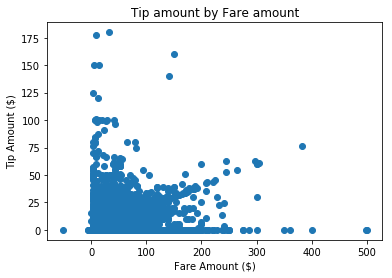

In [3]:
#Plot the data using matplotlib
plt.scatter(df['fare_amount'],df['tip_amount'])
plt.xlabel("Fare Amount ($)")
plt.ylabel("Tip Amount ($)")
plt.title("Tip amount by Fare amount")
plt.show()

# close conenction to sql server
cnxn.close()

In [ ]:
# sql query
query_str='''
select passenger_count 
      ,pickup_datetime  
      ,pickup_longitude
      ,pickup_latitude
      ,dropoff_longitude
      ,dropoff_latitude
      ,fare_amount 
      from [dbo].[nyctaxi_sample]
'''
servername = 'LNOR010941'
db = 'NYCTaxi_Sample'
conn_str = 'Driver=SQL Server;Server=' + servername + \
    ';Database=' + db + ';Trusted_Connection=True;'
cnxn = pyodbc.connect(conn_str)
#cursor = cnxn.cursor()

# Load query into dataframe
df=pd.read_sql(query_str,cnxn)

In [ ]:
df=df.loc[df['fare_amount']>=0]
df['dropoff_latitude_n']=pd.to_numeric(df['dropoff_latitude'])
df['dropoff_longitude_n']=pd.to_numeric(df['dropoff_longitude'])
df['pickup_latitude_n']=pd.to_numeric(df['pickup_latitude'])
df['pickup_longitude_n']=pd.to_numeric(df['pickup_longitude'])
df=df.drop(columns=['dropoff_latitude','dropoff_longitude','pickup_latitude','pickup_longitude'])

In [ ]:
boundary={'min_lng':-74.263242,
              'min_lat':40.573143,
              'max_lng':-72.986532, 
              'max_lat':41.709555}

#We will mark the outlier locations as 1 and remove them for further analysi
df.loc[~((df.pickup_longitude_n >= boundary['min_lng'] ) & (df.pickup_longitude_n <= boundary['max_lng']) &
            (df.pickup_latitude_n >= boundary['min_lat']) & (df.pickup_latitude_n <= boundary['max_lat']) &
            (df.dropoff_longitude_n >= boundary['min_lng']) & (df.dropoff_longitude_n <= boundary['max_lng']) &
            (df.dropoff_latitude_n >=boundary['min_lat']) & (df.dropoff_latitude_n <= boundary['max_lat'])),'is_outlier_loc']=1
df.loc[((df.pickup_longitude_n >= boundary['min_lng'] ) & (df.pickup_longitude_n <= boundary['max_lng']) &
            (df.pickup_latitude_n >= boundary['min_lat']) & (df.pickup_latitude_n <= boundary['max_lat']) &
            (df.dropoff_longitude_n >= boundary['min_lng']) & (df.dropoff_longitude_n <= boundary['max_lng']) &
            (df.dropoff_latitude_n >=boundary['min_lat']) & (df.dropoff_latitude_n <= boundary['max_lat'])),'is_outlier_loc']=0

print("Outlier vs Non Outlier Counts")
print(df['is_outlier_loc'].value_counts())

# Let us drop rows, where location is outlier
df=df.loc[df['is_outlier_loc']==0]
df.drop(['is_outlier_loc'],axis=1,inplace=True)

In [ ]:
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC')
df['pickup_date']=  df['pickup_datetime'].dt.date
df['pickup_day']= df['pickup_datetime'].apply(lambda x:x.day)
df['pickup_hour']= df['pickup_datetime'].apply(lambda x:x.hour)
df['pickup_day_of_week']= df['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
df['pickup_month']= df['pickup_datetime'].apply(lambda x:x.month)
df['pickup_year']= df['pickup_datetime'].apply(lambda x:x.year)
df['is_pickup_JFK']= df.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'JFK'),axis=1)
df['is_dropoff_JFK']= df.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'JFK'),axis=1)
df['is_pickup_EWR']= df.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'EWR'),axis=1)
df['is_dropoff_EWR']= df.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'EWR'),axis=1)
df['is_pickup_la_guardia']= df.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'LaGuardia'),axis=1)
df['is_dropoff_la_guardia']= df.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'LaGuardia'),axis=1)
df['pickup_latitude_round3']= df['pickup_latitude'].apply(lambda x:round(x,3))
df['pickup_longitude_round3']= df['pickup_longitude'].apply(lambda x:round(x,3))
df['dropoff_latitude_round3']= df['dropoff_latitude'].apply(lambda x:round(x,3))
df['dropoff_longitude_round3']= df['dropoff_longitude'].apply(lambda x:round(x,3))
df['trip_distance']= df.apply(lambda row:distance(row['pickup_latitude'],row['dropoff_latitude'],row['pickup_longitude'],row['dropoff_longitude']),axis=1)
df['pickup_borough']= df.apply(lambda row:getBorough(row['pickup_latitude'],row['pickup_longitude']),axis=1)
df['dropoff_borough']= df.apply(lambda row:getBorough(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)
df['is_pickup_lower_manhattan']= df.apply(lambda row:isLowerManhattan(row['pickup_latitude'],row['pickup_longitude']),axis=1)
df['is_dropoff_lower_manhattan']= df.apply(lambda row:isLowerManhattan(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)
df['pickup_day_of_week']= df['pickup_day_of_week'].apply(lambda x:encodeDays(x))
print("Shape of  df data",  df.shape)


In [ ]:
df.to_csv('nyc_data_clean_and_features.csv',index=False)